Following this
---
https://towardsdatascience.com/a-step-by-step-guide-to-feature-engineering-for-multivariate-time-series-162ccf232e2f

In [97]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
plt.style.use('fivethirtyeight')
import seaborn as sns #For heatmap
from utils import add_time_lag_df

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor

%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [99]:
train_a = pd.read_parquet('data/A/train_targets.parquet')
train_b = pd.read_parquet('data/B/train_targets.parquet')
train_c = pd.read_parquet('data/C/train_targets.parquet')

# Estimated training data for each location
X_train_estimated_a = pd.read_parquet('data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('data/C/X_train_estimated.parquet')

# Observed training data for each location
X_train_observed_a = pd.read_parquet('data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('data/C/X_train_observed.parquet')

# Estimated test data for each location
X_test_estimated_a = pd.read_parquet('data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('data/C/X_test_estimated.parquet')

For the sake of it looking at only one dataset.
Might do something else later

In [100]:
X_data = X_train_observed_a
Y_data = train_a
Y_data

,time,pv_measurement
0,2019-06-02 22:00:00,0.00
1,2019-06-02 23:00:00,0.00
2,2019-06-03 00:00:00,0.00
3,2019-06-03 01:00:00,0.00
4,2019-06-03 02:00:00,19.36
...,...,...
34080,2023-04-30 19:00:00,9.02
34081,2023-04-30 20:00:00,0.00
34082,2023-04-30 21:00:00,0.00
34083,2023-04-30 22:00:00,0.00


<Axes: >

Error in callback <function _draw_all_if_interactive at 0x7f9f0f226160> (for post_execute):


ValueError: Date ordinal 3155644.068599987 converts to 10609-11-11T01:38:47.038848 (using epoch 1970-01-01T00:00:00), but Matplotlib dates must be between year 0001 and 9999.

ValueError: Date ordinal 3155644.068599987 converts to 10609-11-11T01:38:47.038848 (using epoch 1970-01-01T00:00:00), but Matplotlib dates must be between year 0001 and 9999.

<Figure size 640x480 with 1 Axes>

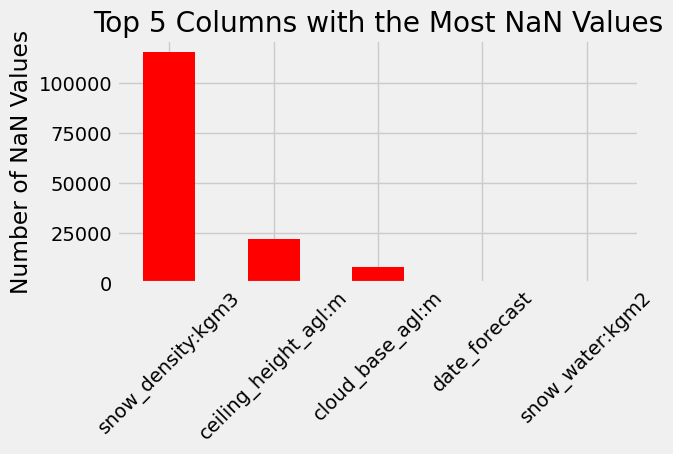

In [101]:
nan_count = X_data.isnull().sum()
sorted_nan_count = nan_count.sort_values(ascending=False)
N = 5  # Change this to the number of columns you want to plot
columns_to_plot = sorted_nan_count.head(N)
plt.figure(figsize=(6, 3))
columns_to_plot.plot(kind='bar', color='red')
plt.title(f'Top {N} Columns with the Most NaN Values')
plt.ylabel('Number of NaN Values')
plt.xticks(rotation=45)
plt.show()

I will remove snow density

In [71]:
X_data.drop(columns=['snow_density:kgm3', 'ceiling_height_agl:m', 'cloud_base_agl:m'], inplace=True)

In [72]:
X_data.rename(columns={'date_forecast': 'time'}, inplace=True)
X_data = X_data.set_index('time')
X_data = X_data.resample('H').mean()

Y_data.set_index('time')
data = pd.merge(X_data, Y_data, on="time")
data.set_index('time', inplace=True)

In [73]:
data = data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x)) #remove the : characters etc. This is due json stuff. clear_sky_rad:W-> clear_sky_radW

In [102]:
import xgboost as xgb

Y = data['pv_measurement']
X = data.drop(columns=['time', 'pv_measurement'])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

reg_full = xgb.XGBRegressor(n_estimators=1000)
reg_full.fit(X, Y)

KeyError: "['time'] not found in axis"

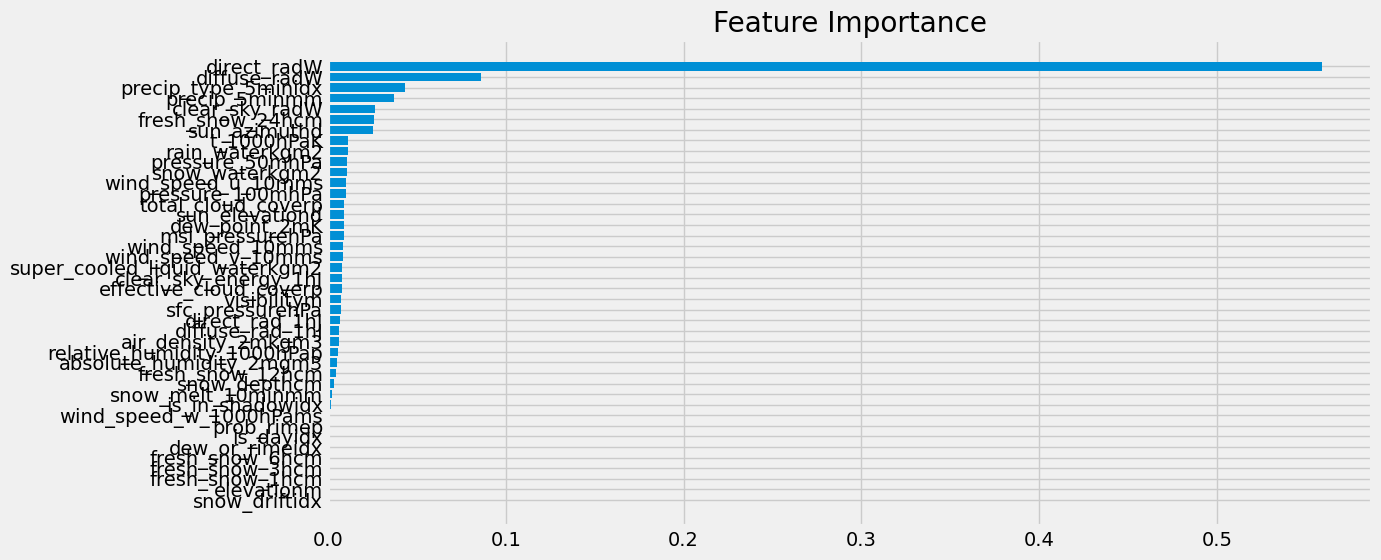

In [103]:

feature_importance = reg_full.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

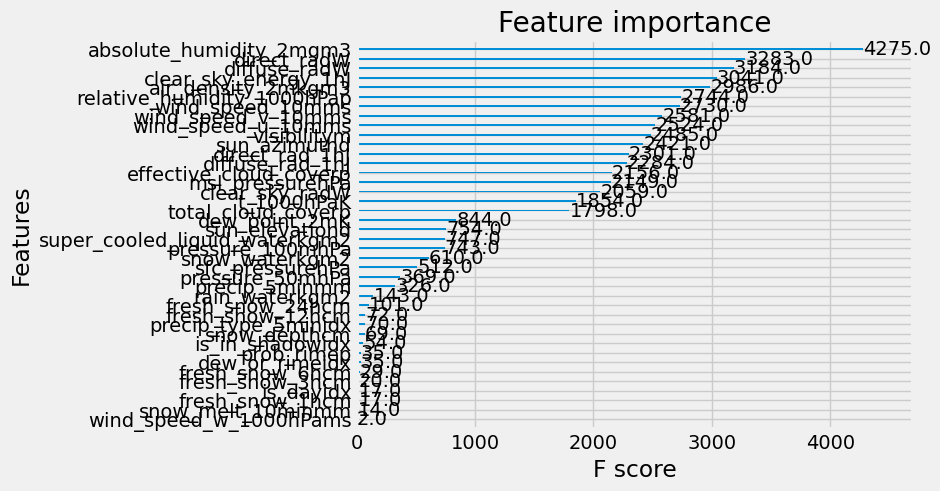

In [104]:
xgb.plot_importance(reg_full)

Laplacian score and variance treshold

In [105]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=round(24*365*0.1), gap=24)
df = data.sort_index()

target = 'pv_measurement'

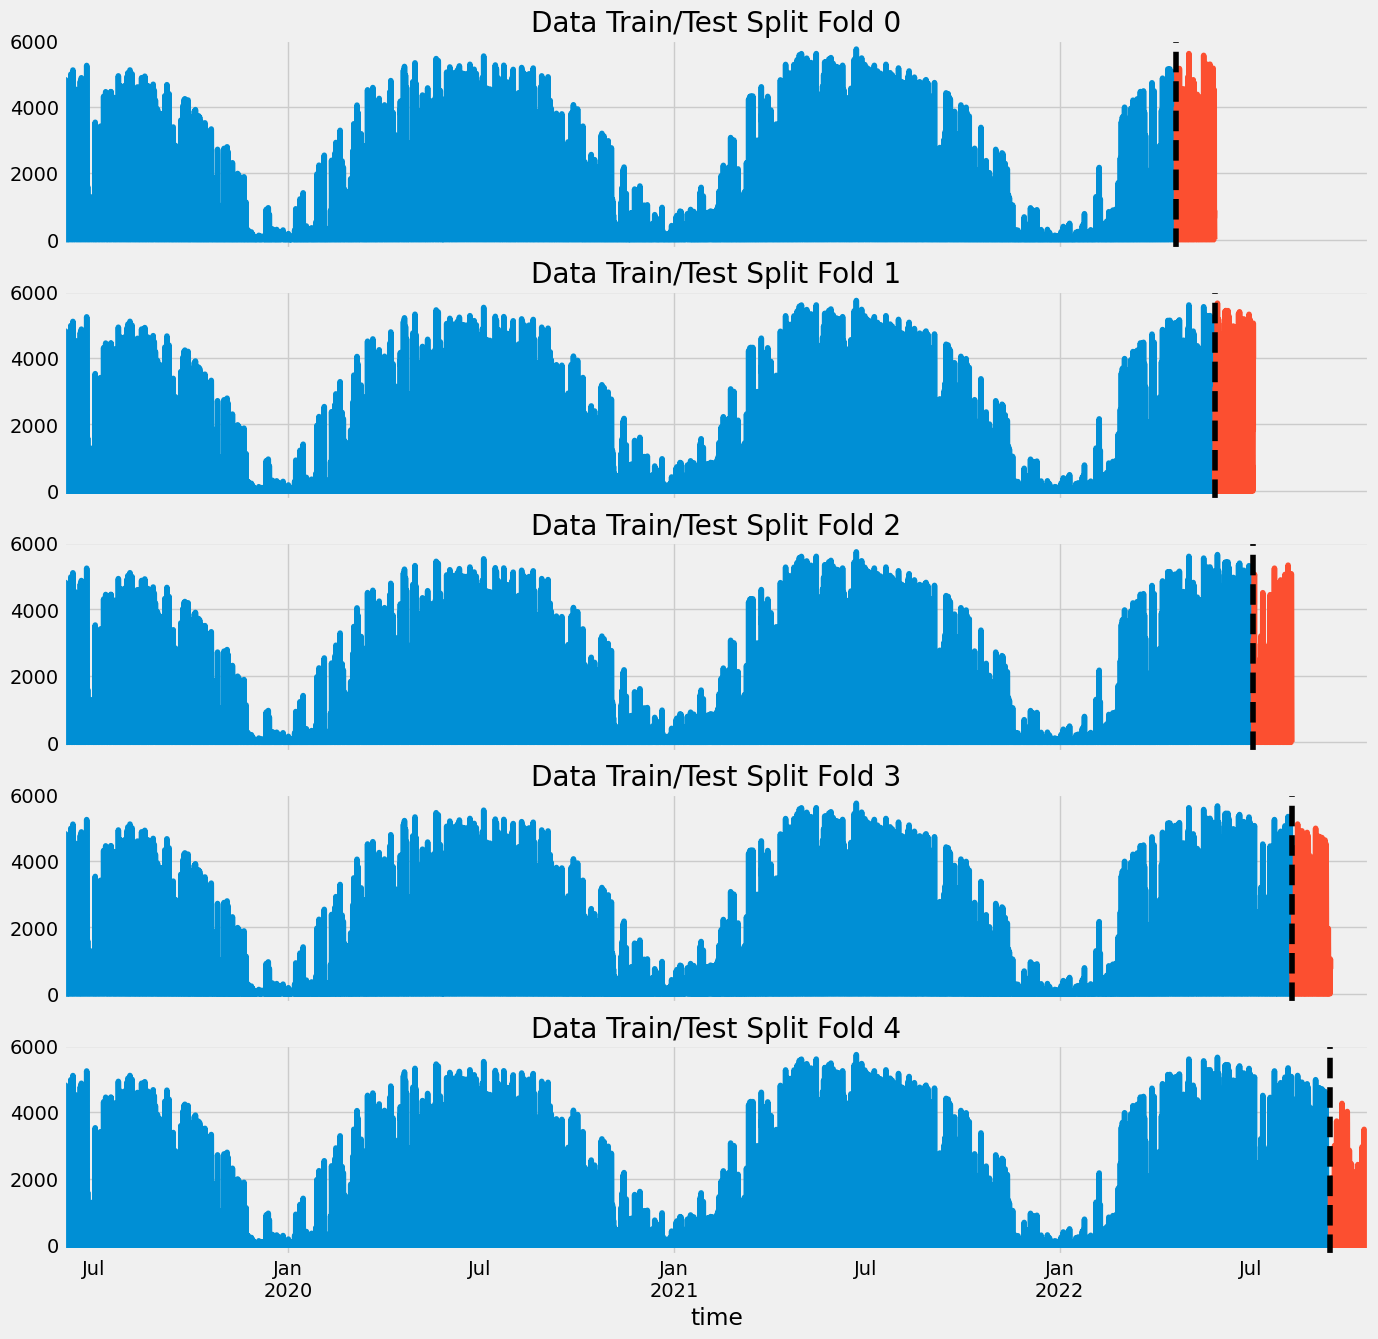

In [106]:
fig, axs = plt.subplots(5, 1, figsize=(15,15), sharex=True)

fold = 0

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train[target].plot(ax=axs[fold],
                       label='Training Set',
                       title=f'Data Train/Test Split Fold {fold}')
    test[target].plot(ax=axs[fold], label="Test Set")
    axs[fold].axvline(test.index.min(), color="black", ls='--')
    fold+=1